# EpigraphDB platform

In this notebook we show the following aspects of the EpiGraphDB platform, and how to use the API to get the information:

1. Metadata: meta nodes and meta edges, and the overall schema.
2. Search for a specific node under the meta node.
3. Cypher: how to query the database directly using Neo4j Cypher

For detailed documentation on the API endpoints please visit:

- The Swagger interface: http://api.epigraphdb.org
- The sections regarding API endpoints on the documentation site: http://docs.epigraphdb.org/api/api-endpoints/

In [1]:
from pprint import pformat

import networkx as nx
import pandas as pd
import requests

In [2]:
API_URL = "http://api.epigraphdb.org"

requests.get(f"{API_URL}/ping").json()

True

## Metadata

Here we query for the metadata information using the endpoint `GET /meta/schema`, which will be used for downstream processing.

In [3]:
endpoint = "/meta/schema"
params = {
    "graphviz": False,
    "plot": False
}
r = requests.get(f"{API_URL}{endpoint}", params=params)
r.raise_for_status()
metadata = r.json()

# Preview of metadata information
keys = metadata.keys()
print(pformat(keys), "\n")
for key in list(keys):
    print(f"# {key}:")
    print(pformat(metadata[key])[:1000], "\n")

dict_keys(['nodes', 'edges', 'connections']) 

# nodes:
{'Disease': {'count': 3312,
             'properties': {'doid': {'indexed': False,
                                     'type': 'STRING',
                                     'unique': False},
                            'name': {'indexed': False,
                                     'type': 'STRING',
                                     'unique': False},
                            'synonym': {'indexed': False,
                                        'type': 'STRING',
                                        'unique': False}}},
 'Drug': {'count': 3061,
          'properties': {'chembl_uri': {'indexed': False,
                                        'type': 'STRING',
                                        'unique': False},
                         'label': {'indexed': True,
                                   'type': 'STRING',
                                   'unique': False},
                         'molecule_type': {'indexed':

### Meta nodes

We can extract the specific meta node information as a pandas dataframe from the metadata.

In [4]:
meta_node_df = pd.DataFrame.from_dict(
    metadata["nodes"], orient="index")

(
    meta_node_df
    .sort_index()
    .assign(count=lambda df: df["count"].apply(lambda x: f"{x:,}"))
)

,count,properties
Disease,"3,312","{'name': {'type': 'STRING', 'indexed': False, ..."
Drug,"3,061","{'phase': {'type': 'INTEGER', 'indexed': False..."
Efo,"21,864","{'type': {'type': 'STRING', 'indexed': False, ..."
Event,"11,868","{'in_disease': {'type': 'STRING', 'indexed': F..."
Gene,"59,172","{'start': {'type': 'INTEGER', 'indexed': False..."
Gtex,53,"{'tissue': {'type': 'STRING', 'indexed': True,..."
Gwas,"21,281","{'note': {'type': 'STRING', 'indexed': False, ..."
Literature,"1,871,731","{'pubmed_id': {'type': 'STRING', 'indexed': Tr..."
MeshTerm,"29,380","{'ui': {'type': 'STRING', 'indexed': True, 'un..."
MeshTree,"58,744","{'id': {'type': 'STRING', 'indexed': True, 'un..."


### Meta relationships and connections

We can also extract the meta relationship (edge) information, and the connections.

In [5]:
meta_rel_df = (
    pd.DataFrame.from_dict(metadata["edges"], orient="index").
    merge(
        pd.DataFrame.from_dict(
            {_["rel"]: _ for _ in metadata["connections"]}, orient="index")
        [["from_node", "to_node"]],
        left_index=True, right_index=True
    )
)

(
    meta_rel_df
    .sort_values(by=["from_node", "to_node"])
    .assign(count=lambda df: df["count"].apply(lambda x: f"{x:,}"))
)

,count,properties,from_node,to_node
DISEASE_TO_EFO,"1,824",None,Disease,Efo
DRUG_TO_DISEASE,158,None,Drug,Disease
CPIC,356,{'pharmgkb_level_of_evidence': {'array': False...,Drug,Gene
OPENTARGETS_DRUG_TO_TARGET,"6,045","{'action_type': {'array': False, 'type': 'STRI...",Drug,Gene
DRUG_TO_LITERATURE,243,None,Drug,Literature
DRUG_TO_PROTEIN,"22,438","{'relation': {'array': False, 'type': 'STRING'...",Drug,Protein
EFO_CHILD_OF,"26,562",None,Efo,Efo
PRECEDING_EVENT,"10,418",None,Event,Event
EXPRESSED_IN,"861,552","{'tpm': {'array': False, 'type': 'FLOAT'}}",Gene,Gtex
XQTL_MR_GENE_GWAS,"10,603,959","{'p': {'array': False, 'type': 'FLOAT'}, 'rsid...",Gene,Gwas


### Schema plot

We can generate a network diagram of the graph db schema using `networkx`.

In [6]:
graph = nx.from_pandas_edgelist(
    meta_rel_df,
    source="from_node", target="to_node"
)

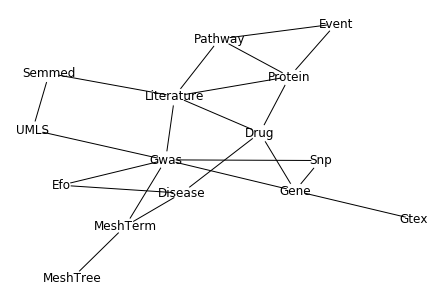

In [7]:
nx.draw(
    G=graph,
    pos=nx.kamada_kawai_layout(graph),
    with_labels=True,
    node_color="white")

A detailed version of the shema plot can be obtained from the API:

![schema_plot](http://ieu-mrbssd1.epi.bris.ac.uk:28046/meta/schema?graphviz=true&plot=true)

## Search for specific node

Users can use [the explorer on the Web UI](http://dev.epigraphdb.org/explore) to search for a specific node by:

- fuzzy matching by "name" field.
- exact matching by "ID" field if you know the its ID (e.g. the ID to a GWAS from IEU GWAS Database).

Here we show how these are done at the API level using `Gwas` nodes as an example.

First we need to know what the "ID" and "name" fields are for the meta nodes using `GET /meta/nodes/id-name-schema`:

In [8]:
r = requests.get(f"{API_URL}/meta/nodes/id-name-schema")
r.raise_for_status()

meta_node_fields = r.json()
meta_node_fields

{'Disease': {'id': 'id', 'name': 'label'},
 'Drug': {'id': 'label', 'name': 'label'},
 'Efo': {'id': 'id', 'name': 'value'},
 'Event': {'id': 'reactome_id', 'name': 'name'},
 'Gene': {'id': 'ensembl_id', 'name': 'name'},
 'Gtex': {'id': 'tissue', 'name': 'tissue'},
 'Gwas': {'id': 'id', 'name': 'trait'},
 'Literature': {'id': 'pubmed_id', 'name': 'pubmed_id'},
 'Pathway': {'id': 'reactome_id', 'name': 'name'},
 'Protein': {'id': 'uniprot_id', 'name': 'uniprot_id'},
 'SemmedTerm': {'id': 'id', 'name': 'name'},
 'Variant': {'id': 'name', 'name': 'name'}}

### Fuzzy matching

Here we search for nodes can contain "body mass index" in their traits.

In [9]:
name = "body mass index"

r = requests.get(f"{API_URL}/meta/nodes/Gwas/search", params={"name": name})
r.raise_for_status()

print(pformat(r.json())[:3000])

{'metadata': {'empty_results': False,
              'query': 'MATCH (node: Gwas) WHERE node.trait =~ "(?i).*body '
                       'mass index.*" RETURN node LIMIT 10;',
              'total_seconds': 0.127409},
 'results': [{'node': {'access': 'public',
                       'author': 'Locke AE',
                       'category': 'Risk factor',
                       'consortium': 'NA',
                       'id': 'ieu-a-2',
                       'mr': '1',
                       'nsnp': '2555511',
                       'pmid': '25673413',
                       'population': 'Mixed',
                       'priority': '1',
                       'sample_size': '339224',
                       'sd': '4.77',
                       'sex': 'Males and Females',
                       'subcategory': 'Anthropometric',
                       'trait': 'Body mass index',
                       'unit': 'NA',
                       'year': '2015'}},
             {'node': {'access': '

### Exact matching

Similarly, we can exact match a specific node by its ID.

In [10]:
id = "ieu-a-2"

r = requests.get(f"{API_URL}/meta/nodes/Gwas/search", params={"id": id})
r.raise_for_status()

print(pformat(r.json())[:3000])

{'metadata': {'empty_results': False,
              'query': 'MATCH (node: Gwas {id: "ieu-a-2"}) RETURN node LIMIT '
                       '10;',
              'total_seconds': 0.003239},
 'results': [{'node': {'access': 'public',
                       'author': 'Locke AE',
                       'category': 'Risk factor',
                       'consortium': 'NA',
                       'id': 'ieu-a-2',
                       'mr': '1',
                       'nsnp': '2555511',
                       'pmid': '25673413',
                       'population': 'Mixed',
                       'priority': '1',
                       'sample_size': '339224',
                       'sd': '4.77',
                       'sex': 'Males and Females',
                       'subcategory': 'Anthropometric',
                       'trait': 'Body mass index',
                       'unit': 'NA',
                       'year': '2015'}}]}


## Cypher (advanced)

Advanced users that are familiar with Neo4j Cypher can query the database using Cypher directly.

In [13]:
query = """
    MATCH (exposure:Gwas)-[mr:MR]->(outcome:Gwas) 
    WHERE exposure.trait = "Body mass index"
    RETURN exposure, outcome, mr LIMIT 2
"""

r = requests.post(f"{API_URL}/cypher", json={"query": query})
r.raise_for_status()

print(pformat(r.json())[:3000])

{'metadata': {'empty_results': False,
              'query': 'MATCH (exposure:Gwas)-[mr:MR]->(outcome:Gwas) WHERE '
                       'exposure.trait = "Body mass index" RETURN exposure, '
                       'outcome, mr LIMIT 2',
              'total_seconds': 0.259296},
 'results': [{'exposure': {'access': 'public',
                           'author': 'Locke AE',
                           'category': 'Risk factor',
                           'consortium': 'NA',
                           'id': 'ieu-a-2',
                           'mr': '1',
                           'nsnp': '2555511',
                           'pmid': '25673413',
                           'population': 'Mixed',
                           'priority': '1',
                           'sample_size': '339224',
                           'sd': '4.77',
                           'sex': 'Males and Females',
                           'subcategory': 'Anthropometric',
                           'trait': 'Body ma

Alternatively we provide an endpoint `POST /cypher/builder/plain` that assist users in querying for simple cypher queries.

In [14]:
payload = {
    "source_meta_node": "Gwas",
    "target_meta_node": "Gwas",
    "meta_rel": "MR",
    "where": ["source_node.trait = 'Body mass index'"],
    "limit": 2
}

r = requests.post(f"{API_URL}/cypher/builder/plain", json=payload)
r.raise_for_status()

print(pformat(r.json())[:3000])

{'metadata': {'empty_results': False,
              'query': 'MATCH (source_node:Gwas) -[rel:MR]- (target_node:Gwas) '
                       "WHERE source_node.trait = 'Body mass index' RETURN "
                       'source_node, rel, target_node LIMIT 2',
              'total_seconds': 0.031114},
 'results': [{'rel': {'b': 0.0030348598957061768,
                      'ci_low': -0.002742477459833026,
                      'ci_upp': 0.008812196552753448,
                      'log10pval': 1.0,
                      'method': 'Weighted median',
                      'moescore': 0.7799999713897705,
                      'nsnp': 77,
                      'pval': 0.3032084107398987,
                      'se': 0.002947675297036767,
                      'selection': 'DF + HF'},
              'source_node': {'access': 'public',
                              'author': 'Locke AE',
                              'category': 'Risk factor',
                              'consortium': 'NA',
    

Again for the detailed documentation on the API endpoints please visit:

- The Swagger interface: http://api.epigraphdb.org
- The sections regarding API endpoints on the documentation site: http://docs.epigraphdb.org/api/api-endpoints/